In [1]:
from IPython.display import clear_output

!wget -O event_log.xes https://www.dropbox.com/scl/fi/i8merw148h8993a2jt84o/BPI_Challenge_2013_incidents.xes?rlkey=7479muz9r2gqo60w0o06hixzu&dl=1

clear_output()
print("Log loaded.")

Log loaded.


In [2]:
!pip install mpvis
!pip install pm4py

clear_output()
print("Packages installed.")

Packages installed.


In [3]:
import mpvis
from mpvis import mddrt
from mpvis import mpdfg
import pm4py
import pandas as pd
from datetime import datetime
from IPython.display import SVG, display
clear_output()

In [4]:
event_log = pm4py.read_xes('event_log.xes')

# Consider lifecycle information
event_log['concept:name'] = event_log['concept:name'].str.cat(event_log['lifecycle:transition'], sep = ' | ')

log_format = {'case:concept:name': 'case:concept:name',
              'concept:name': 'concept:name',
              'time:timestamp': 'time:timestamp',
              'start_timestamp': '',
              'org:resource': 'org:resource',
              'cost:total': ''}

event_log = mpvis.log_formatter(event_log.copy(), log_format)

parsing log, completed traces ::   0%|          | 0/7554 [00:00<?, ?it/s]

In [5]:
print("Case count: " + str(len(set(event_log['case:concept:name']))))
print("Variant count: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Event count: " + str(len(event_log['case:concept:name'])))
print("Activity count: " + str(len(set(event_log['concept:name']))))

Case count: 7554
Variant count: 2278
Event count: 65533
Activity count: 13


In [6]:
mpdfg_discovery_start = datetime.now()

dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(event_log.copy())

mpdfg_discovery_end = datetime.now()

print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 18.301991 seconds.


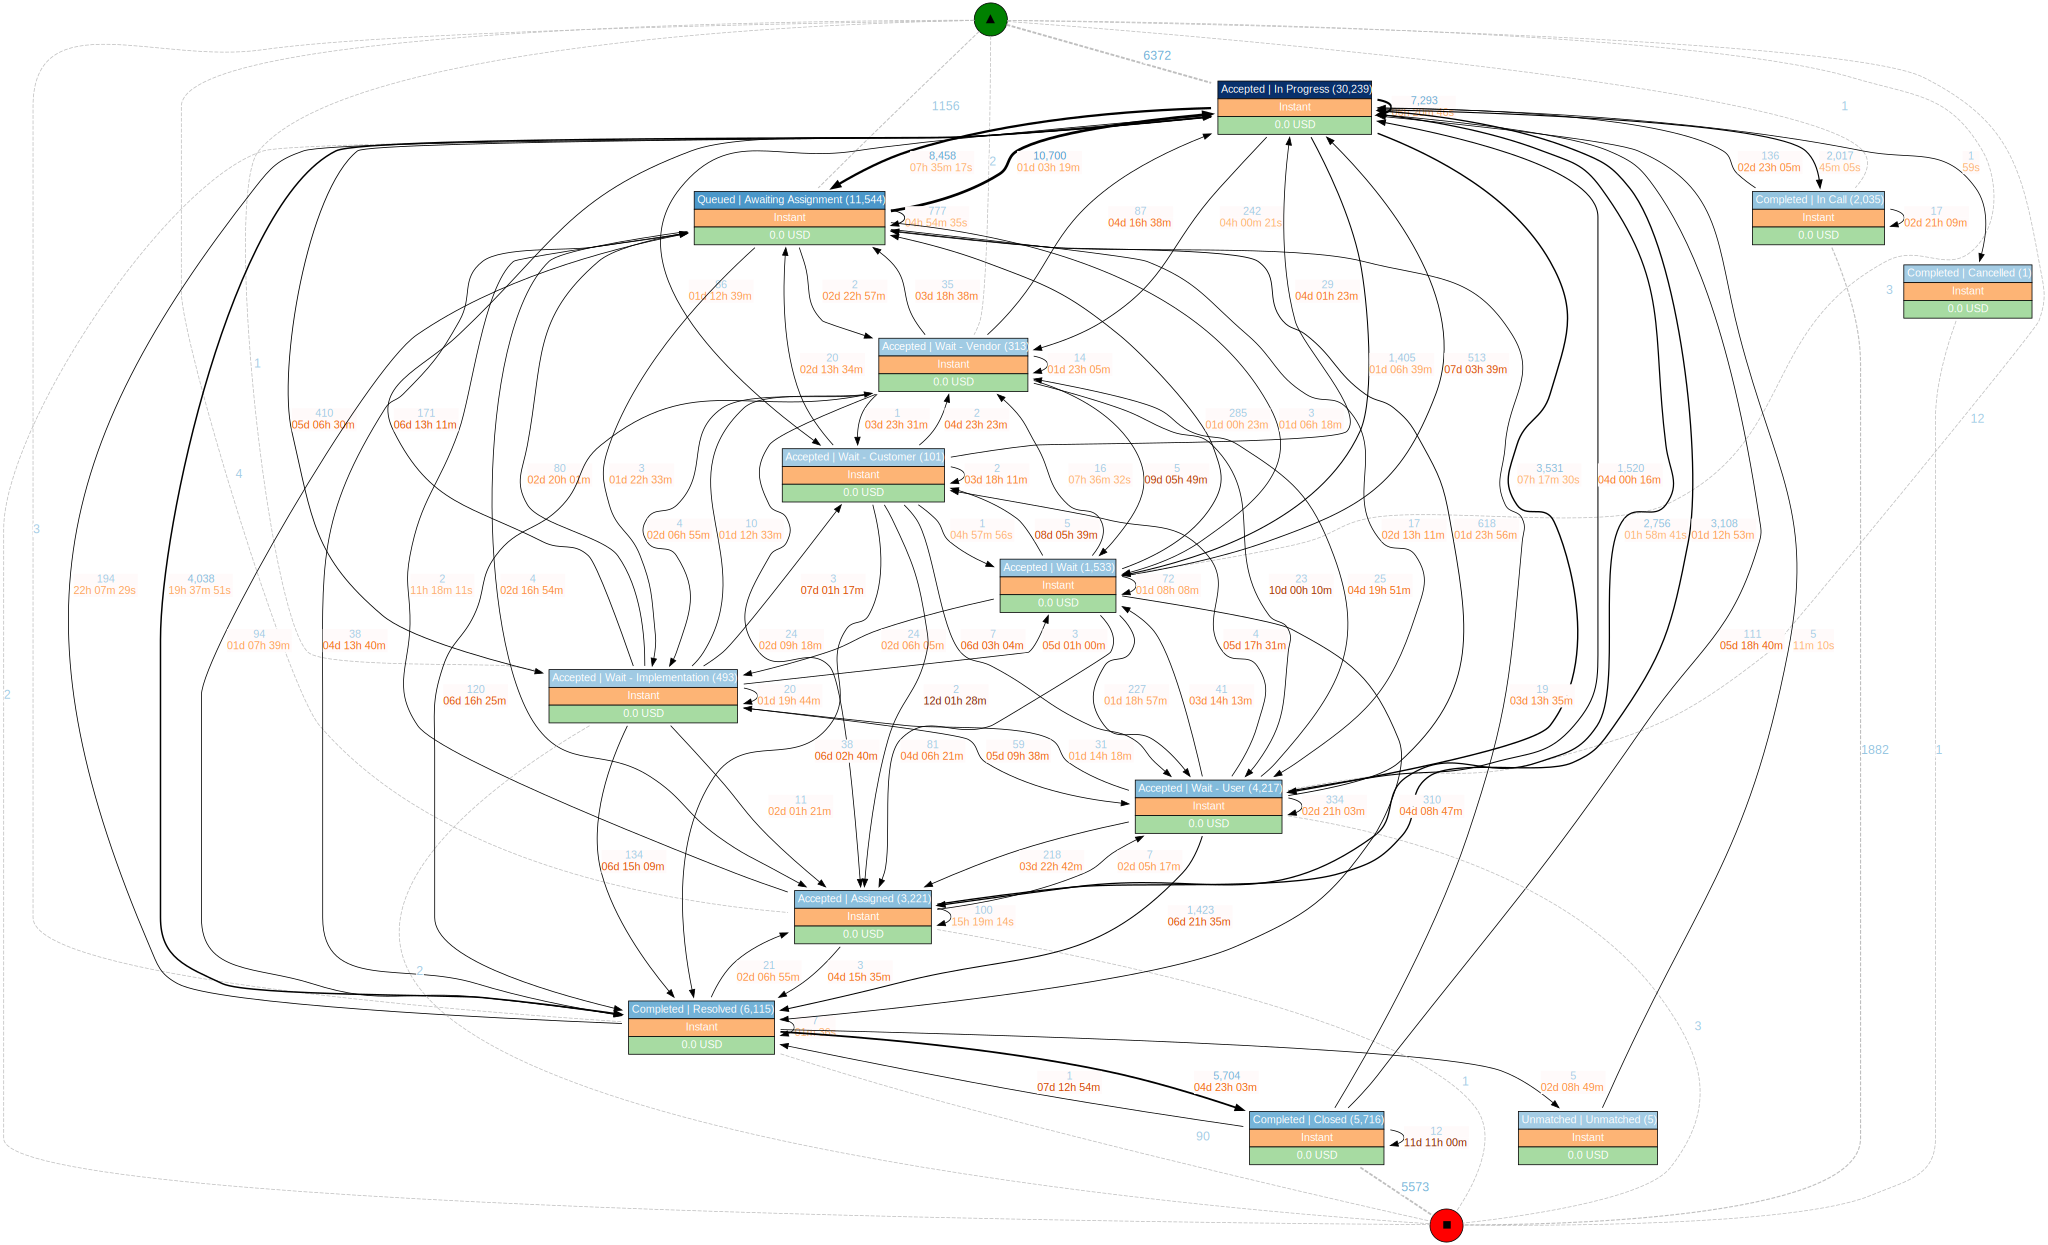

MP-DFG visualization time: 0.251167 seconds.


In [7]:
mpdfg_visualization_start = datetime.now()

mpdfg.view_multi_perspective_dfg(dfg, start_activities, end_activities)

mpdfg_visualization_end = datetime.now()

print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")

In [8]:
mddrt_discovery_start = datetime.now()

drt = mddrt.discover_multi_dimensional_drt(event_log.copy())

mddrt_discovery_end = datetime.now()

print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")

Calculating log mandatory activities: 


100%|██████████| 7554/7554 [01:00<00:00, 124.95it/s]


Calculating log metrics: 


100%|██████████| 7554/7554 [01:06<00:00, 113.33it/s]


Building Tree Cases:


100%|██████████| 7554/7554 [00:47<00:00, 158.23it/s]


Building Tree Graph:


100%|██████████| 7554/7554 [00:01<00:00, 4309.74it/s]


MD-DRT discovery time: 177.135583 seconds.


In [9]:
mddrt_visualization_start = datetime.now()

mddrt.view_multi_dimensional_drt(drt)

mddrt_visualization_end = datetime.now()

print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

Output hidden; open in https://colab.research.google.com to view.

In [10]:
print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")
print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")
print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 18.301991 seconds.
MP-DFG visualization time: 0.251167 seconds.
MD-DRT discovery time: 177.135583 seconds.
MD-DRT visualization time: 484.851208 seconds.


In [11]:
# A copy of the original log is used to allow comparing the processed and original logs
processed_log = event_log.copy()

In [12]:
# The activities of the original log differentiate between different 'Wait' lifecycle transitions, separated by '-' (e.g., 'Wait - Implementation')
# To reduce the number of activities, 'Wait' transitions are renamed to a unique name
processed_log['concept:name'] = processed_log['concept:name'].str.split(' - ').str[0]

print("Activity count before: " + str(len(set(event_log['concept:name']))))
print("Activity count after: " + str(len(set(processed_log['concept:name']))))

Activity count before: 13
Activity count after: 9


In [13]:
# Some activities occur only 1-5 times
# Cases containing these activities are removed, as their inclusion increments the complexity of the process models without providing additional insights
processed_log = pm4py.filter_event_attribute_values(processed_log, 'concept:name', ['Unmatched | Unmatched', 'Completed | Cancelled'], level = 'case', retain = False)

# Moreover, the original log contains some cases that seem to be incomplete (e.g., they do not start or end with a valid activity)
# Only cases that start with 'Accepted | In Progress' or 'Queued | Awaiting Assignment', and that end with 'Completed | Closed' or 'Completed | In Call' will be considered
processed_log = pm4py.filter_start_activities(processed_log, ['Accepted | In Progress', 'Queued | Awaiting Assignment'])
processed_log = pm4py.filter_end_activities(processed_log, ['Completed | Closed', 'Completed | In Call'])

print("Case count before: " + str(len(set(event_log['case:concept:name']))))
print("Case count after: " + str(len(set(processed_log['case:concept:name']))))

Case count before: 7554
Case count after: 7440


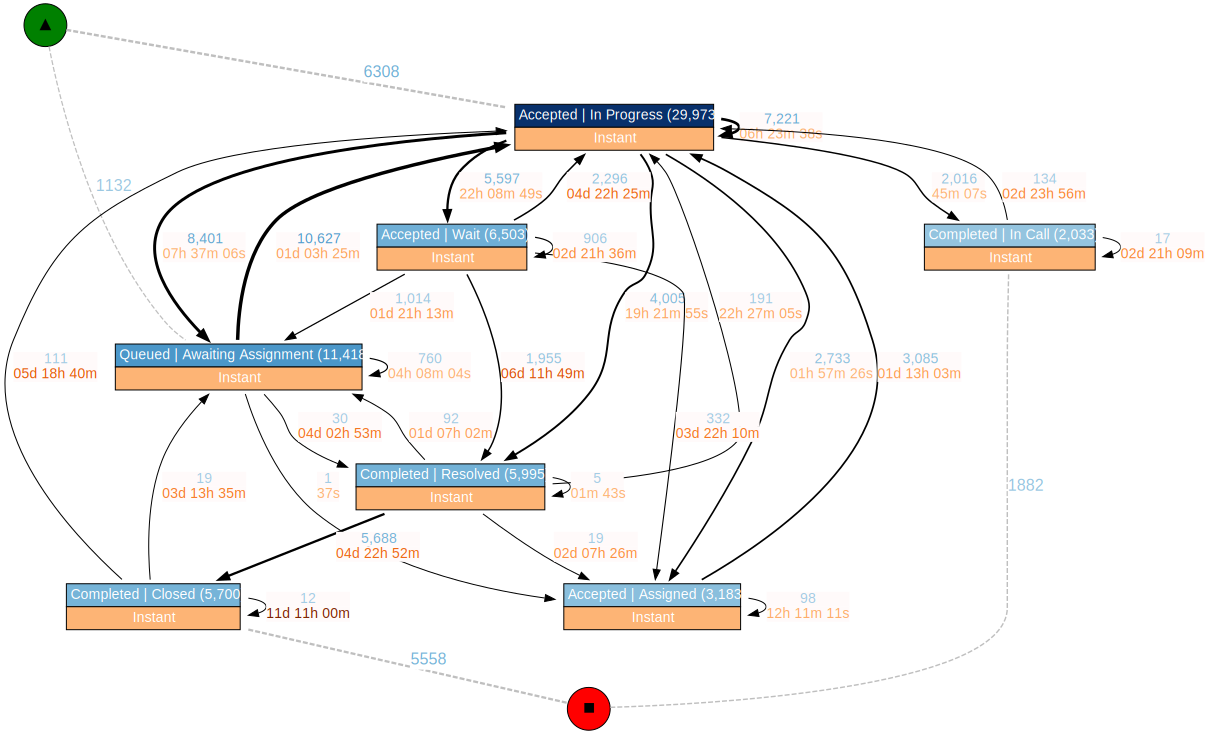

In [14]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy())

mpdfg.save_vis_multi_perspective_dfg(dfg, start_activities, end_activities, file_name = 'dfg_processed_log_100_100', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_processed_log_100_100.svg'))

In [15]:
# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(processed_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_processed_log_autogroup', visualize_cost = False)
display(SVG(filename = 'drt_processed_log_autogroup.svg'))

Output hidden; open in https://colab.research.google.com to view.